# Análise de distribuição de itens - Apriori

Trabalho realizado para a disciplina de Inteligência Artificial

Departamento de Ciência da Computação - Universidade de Brasília

In [1]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('groceries_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-05-01,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-01-02,whole milk


In [3]:
# There are no NaN values
df.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [4]:
print('Número de registros: ', df.shape[0])
print('Número de clientes: ', df['Member_number'].unique().shape[0])
print('Número de produtos: ', df['itemDescription'].unique().shape[0])
print(f"Data de início/final da coleta: {min(df['Date'])} - {max(df['Date'])}")

Número de registros:  38765
Número de clientes:  3898
Número de produtos:  167
Data de início/final da coleta: 2014-01-01 00:00:00 - 2015-12-30 00:00:00


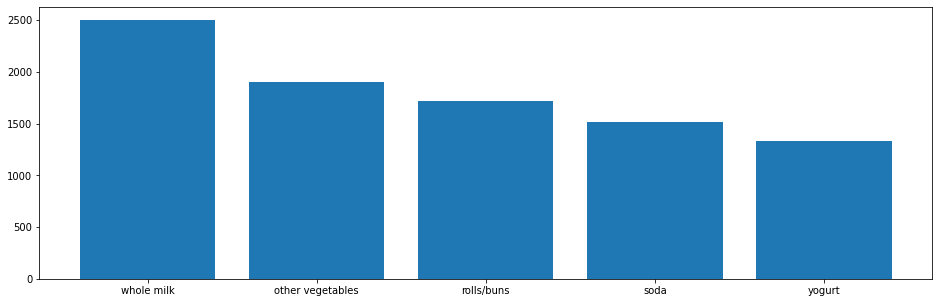

In [5]:
plt.figure(figsize=(16, 5))
count = pd.DataFrame(df['itemDescription'].value_counts().head(5))
plt.bar(count.index, count['itemDescription'])
plt.show()

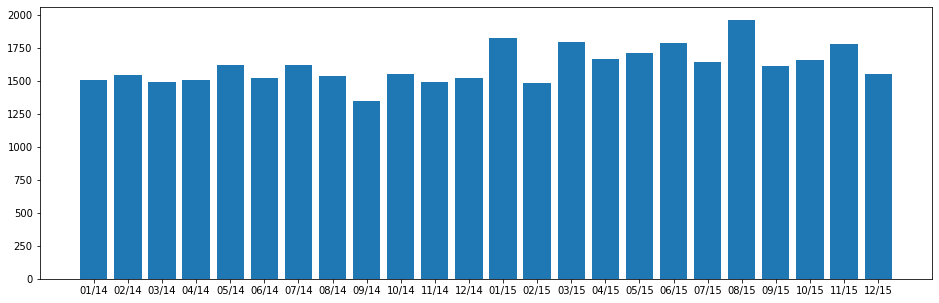

In [6]:
plt.figure(figsize=(16, 5))
df.index = pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.drop(['Date'], axis=1, inplace=True)
months = df.groupby(pd.Grouper(freq='M'))

x = []
y = []

for month in months:
    x.append(month[0].strftime("%m/%y"))
    y.append(month[1].shape[0])

plt.bar(x, y)
plt.show()

In [7]:
print(df.shape[0])
df = df.drop_duplicates(['Member_number','itemDescription'])
print(df.shape[0])

38765
34766


In [8]:
df['values'] = 1
df_pivot = df.pivot(index='Member_number', columns='itemDescription', values='values').fillna(0)
df_pivot = df_pivot.astype('int64')
df_pivot.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Apriori

O algoritmo Apriori calcula a probabilidade de um cliente comprar o produto P2 se já adquiriu o produto P1. Ele faz isso computando o suporte, a confiança e o "lift" para diferentes combinações de produtos.

O suporte de um produto (ou de um conjunto de produtos) é tido como a probabilidade dos usuários comprarem o produto P, definido por:

$$Suporte(P) = \frac{Numero \: de\: clientes\: que\: compraram\: P}{Numero\: total\: de\: clientes}$$

Como esse cálculo é feito para cada possível combinação de produtos do dataset, uma técnica sugerida para economizar recursos computacionais é a definição de um threshold para o suporte mínimo de um produto. Desse modo, produtos que estejam abaixo desse limiar não são considerados na hora de montar essas combinações.

O cálculo do suporte foi feito com auxílio do método apriori com o parâmetro de suporte mínimo igual a 0.07, ou seja, queremos considerar apenas os produtos (ou conjunto de produtos) que tenham sido adquiridos por pelo menos 7% dos clientes. Desse modo, foram formadas 83 possíveis combinações.

In [9]:
frequent_itemset = apriori(df_pivot, min_support=0.07, use_colnames=True)
print('Número de conjuntos formados', frequent_itemset.shape[0])
frequent_itemset.head()

Número de conjuntos formados 83


,support,itemsets
0,0.078502,(UHT-milk)
1,0.119548,(beef)
2,0.079785,(berries)
3,0.158799,(bottled beer)
4,0.213699,(bottled water)


A confiança é o cálculo de quantos clientes compraram o produto P2 dentre os que compraram o produto P1, definido por:

$$Confianca(P1\rightarrow P2) = \frac{Clientes\: que\: compraram\: P1\: e\: P2}{Clientes\: que\: compraram\: P1} $$

O lift é a proporção entre confiança e suporte. Um lift alto sugere que há alguma relação entre os dois produtos e a maioria dos clientes que compraram o produto P1 provavelmente comprarão o produto P2.
$$Lift(P1\rightarrow P2) = \frac{Confianca(P1\rightarrow P2) }{Suporte(P1)}$$

O cálculo do lift e da confiança é feito por meio do método association_rules da biblioteca mlxtend.frequent_patterns. O dataframe obtido foi ordenado de modo decrescente a partir da coluna de lift, apresentando primeiramente os itens com maior relação.


In [10]:
rules = association_rules(frequent_itemset, metric="lift", min_threshold=1).sort_values(by=['lift'], ascending=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
95,(yogurt),"(whole milk, other vegetables)",0.282966,0.191380,0.071832,0.253853,1.326434,0.017678,1.083727
94,"(whole milk, other vegetables)",(yogurt),0.191380,0.282966,0.071832,0.375335,1.326434,0.017678,1.147870
96,(whole milk),"(yogurt, other vegetables)",0.458184,0.120318,0.071832,0.156775,1.303003,0.016704,1.043235
93,"(yogurt, other vegetables)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,0.016704,1.344507
69,(sausage),(yogurt),0.206003,0.282966,0.075423,0.366127,1.293892,0.017132,1.131196


## Recomendação de itens

In [15]:
selected_item = 'soda'
df_item = rules[rules['antecedents'].apply(lambda x: len(x) == 1 and next(iter(x)) == selected_item)]
print('Número de combinações possíveis que se relacionam com a compra do item: ', df_item.shape[0])
df_item.head()

Número de combinações possíveis que se relacionam com a compra do item:  8


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,(soda),(sausage),0.313494,0.206003,0.077219,0.246318,1.195698,0.012638,1.053490
7,(soda),(bottled water),0.313494,0.213699,0.076193,0.243044,1.137318,0.009199,1.038767
59,(soda),(root vegetables),0.313494,0.230631,0.081324,0.259411,1.124787,0.009022,1.038861
73,(soda),(tropical fruit),0.313494,0.233710,0.081837,0.261047,1.116974,0.008570,1.036995
77,(soda),(yogurt),0.313494,0.282966,0.097486,0.310966,1.098952,0.008778,1.040637


In [14]:
items = df_item['consequents'].values

item_list = []
for item in items:
    for title in item:
        if title not in item_list:
            item_list.append(title)

item_list

['sausage',
 'bottled water',
 'root vegetables',
 'tropical fruit',
 'yogurt',
 'rolls/buns',
 'whole milk',
 'other vegetables']